<a href="https://colab.research.google.com/github/ReynadelYolo/ML_Projects/blob/main/MultimodalFashionChat_V5_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#CELL 1:  DEPENDENCIES

# ML & Deep Learning
!pip install -q torch torchvision torchaudio
!pip install -q transformers datasets

# Image Processing
!pip install -q opencv-python-headless Pillow

# Audio Processing & Recognition
!pip install -q openai-whisper librosa soundfile  # or faster-whisper

# NLP
!pip install -q sentence-transformers

# Vector Search & Similarity
!pip install -q faiss-cpu

# UI
!pip install -q streamlit
!pip install -q fastapi uvicorn  # optional for API backend

# Data Visualization
!pip install -q pandas numpy scikit-learn matplotlib seaborn tqdm

# LLM & Efficient Inference (Optional - for intent/response generation)
!pip install -q unsloth
!pip install -q --no-deps xformers trl peft accelerate bitsandbytes

print("✅ All dependencies installed!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.2/803.2 kB 24.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.8/23.8 MB 61.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 94.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 101.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 405.7/405.7 kB 41.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.8/506.8 kB 46.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 423.1/423.1 kB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 kB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 MB 9.1 MB/s

In [ ]:
# CELL 2: IMPORTS AND CONFIGURATION

# Core Libraries
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import pickle
import logging
import os
import re
import json
from typing import Optional, List, Dict, Tuple
from tqdm import tqdm

# Computer Vision & Image Processing
import cv2
from PIL import Image
from torchvision import transforms

# NLP & Embeddings
from sentence_transformers import SentenceTransformer  # CRITICAL ADDITION

# Hugging Face
from datasets import load_dataset
from transformers import (
    CLIPProcessor, CLIPModel,
    BertTokenizer, BertModel,
    WhisperProcessor, WhisperForConditionalGeneration,
    AutoTokenizer, AutoModelForSeq2SeqLM  # For optional LLM
)

# Audio Processing
import librosa
import soundfile as sf

# Vector Search
import faiss
from faiss import IndexFlatIP, IndexFlatL2, normalize_L2

# UI & API (for later integration - COMMENTED OUT TO AVOID ERRORS)
# import streamlit as st  # Uncomment when building UI
# from fastapi import FastAPI, UploadFile, File  # Uncomment for API

# Logging Configuration
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# Device Configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🖥️ Using device: {DEVICE}")

# Configuration - ALIGNED WITH MULTIMODAL CHATBOT DOCUMENT
CONFIG = {
    # Vision Models (Document Section 3.1)
    "CLIP_MODEL": "openai/clip-vit-base-patch32",

    # Text Models (Document Section 3.3)
    "SENTENCE_MODEL": "all-MiniLM-L6-v2",  # CRITICAL: Document specifies this
    "BERT_MODEL": "bert-base-uncased",  # For optional intent classification

    # Speech Models (Document Section 3.2)
    "WHISPER_MODEL": "openai/whisper-small",  # FIXED: Document recommends small for accuracy/speed balance
    # "FASTER_WHISPER": True,  # Option to use faster-whisper later

    # Optional LLM (for intent/response generation - Document mentions but not required)
    "LLM_MODEL": "unsloth/Llama-3.2-1B-Instruct-bnb-4bit",  # Optional

    # Dimensions & Limits
    "CLIP_EMBEDDING_DIM": 512,
    "SENTENCE_EMBEDDING_DIM": 384,  # For all-MiniLM-L6-v2
    "MAX_TEXT_LENGTH": 128,
    "IMAGE_SIZE": 224,  # CLIP standard input size

    # Search & Results
    "TOP_K_RESULTS": 10,
    "FAISS_INDEX_TYPE": "IndexFlatIP",  # Inner Product for cosine similarity

    # Intent Classification (if not using LLM)
    "NUM_INTENTS": 6  # Updated to match document intents
}

# Intent labels (ALIGNED WITH DOCUMENT SECTION 3.3)
INTENT_LABELS = {
    0: "FIND_SIMILAR",       # "find_similar" from document
    1: "FILTER_PRICE",       # "filter_price" from document
    2: "FILTER_COLOR",       # "filter_color" from document
    3: "COMPARE_PRODUCTS",   # "compare_products" from document
    4: "GET_PRODUCT_INFO",   # "faq" equivalent from document
    5: "FILTER_CATEGORY"     # Additional useful filter
}

print("✅ Configuration loaded!")

In [ ]:
# CELL 3: DATA LOADING & PREPROCESSING - HYBRID APPROACH

from datasets import load_dataset, DatasetDict
import pandas as pd
import numpy as np
import os
import json
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO
import random

# ================================
# CONFIGURATION
# ================================
DATASET_MODE = "hybrid"  # Options: "product", "fashionpedia", "hybrid", "synthetic"
SYNTHETIC_PRICES = True   # Generate prices for Fashionpedia items
SAMPLE_SIZE = 5000        # Limit samples for faster processing (None for all)

print(f"📊 Dataset Mode: {DATASET_MODE}")
print(f"💰 Synthetic Prices: {SYNTHETIC_PRICES}")

# ================================
# 1. LOAD FASHIONPEDIA DATASET
# ================================
fashionpedia_df = None
if DATASET_MODE in ["fashionpedia", "hybrid"]:
    print("\n📥 Loading Fashionpedia dataset...")
    try:
        # Load Fashionpedia dataset
        fashionpedia = load_dataset("detection-datasets/fashionpedia", split="train")

        # Convert to pandas for easier manipulation
        fashionpedia_df = fashionpedia.to_pandas()

        # Take a sample if specified
        if SAMPLE_SIZE and len(fashionpedia_df) > SAMPLE_SIZE:
            fashionpedia_df = fashionpedia_df.sample(SAMPLE_SIZE, random_state=42).reset_index(drop=True)

        # Extract basic information from annotations
        print("🔍 Processing Fashionpedia annotations...")

        # Parse the complex annotations
        def parse_fashionpedia_annotations(ann):
            """Extract useful information from Fashionpedia annotations"""
            if not ann or len(ann) == 0:
                return {"categories": [], "attributes": [], "object_count": 0}

            categories = []
            attributes = []

            for obj in ann:
                if 'category_name' in obj:
                    categories.append(obj['category_name'])
                if 'attribute_names' in obj:
                    attributes.extend(obj['attribute_names'])

            return {
                "categories": list(set(categories)),
                "attributes": list(set(attributes)),
                "object_count": len(ann)
            }

        # Apply parsing
        annotations_data = fashionpedia_df['objects'].apply(parse_fashionpedia_annotations)

        # Create new columns
        fashionpedia_df['categories'] = annotations_data.apply(lambda x: x['categories'])
        fashionpedia_df['attributes'] = annotations_data.apply(lambda x: x['attributes'])
        fashionpedia_df['object_count'] = annotations_data.apply(lambda x: x['object_count'])

        # Create text description from categories and attributes
        fashionpedia_df['description'] = fashionpedia_df.apply(
            lambda row: f"{', '.join(row['categories'])} with {', '.join(row['attributes'][:5])}"
            if row['categories'] and row['attributes'] else "Fashion item",
            axis=1
        )

        # Create product display name
        fashionpedia_df['productDisplayName'] = fashionpedia_df['categories'].apply(
            lambda cats: f"{cats[0] if cats else 'Fashion Item'} from Fashionpedia"
        )

        # Generate synthetic prices if needed
        if SYNTHETIC_PRICES:
            print("💰 Generating synthetic prices for Fashionpedia items...")
            # Price ranges based on categories
            price_ranges = {
                'dress': (49.99, 199.99),
                'shirt': (29.99, 89.99),
                'pants': (39.99, 129.99),
                'shoes': (59.99, 249.99),
                'jacket': (79.99, 299.99),
                'skirt': (34.99, 99.99),
                'default': (19.99, 149.99)
            }

            def generate_price(categories):
                if not categories:
                    return round(random.uniform(29.99, 99.99), 2)

                main_category = categories[0].lower()
                for key in price_ranges:
                    if key in main_category:
                        min_price, max_price = price_ranges[key]
                        return round(random.uniform(min_price, max_price), 2)

                min_price, max_price = price_ranges['default']
                return round(random.uniform(min_price, max_price), 2)

            fashionpedia_df['price'] = fashionpedia_df['categories'].apply(generate_price)

        # Create image path/URL (Fashionpedia uses COCO URLs)
        fashionpedia_df['image_url'] = fashionpedia_df['coco_url']
        fashionpedia_df['image_path'] = fashionpedia_df['image_url']  # Using URL as path for now

        # Create color from attributes
        color_keywords = ['red', 'blue', 'green', 'black', 'white', 'yellow',
                         'pink', 'purple', 'orange', 'brown', 'gray', 'grey']

        def extract_color(attributes):
            if not attributes:
                return random.choice(['black', 'white', 'blue', 'red'])
            attrs_lower = [attr.lower() for attr in attributes]
            for color in color_keywords:
                if color in ' '.join(attrs_lower):
                    return color
            return random.choice(['black', 'white', 'blue', 'red'])

        fashionpedia_df['baseColour'] = fashionpedia_df['attributes'].apply(extract_color)

        # Create category columns
        fashionpedia_df['masterCategory'] = fashionpedia_df['categories'].apply(
            lambda cats: cats[0] if cats else 'Clothing'
        )
        fashionpedia_df['subCategory'] = fashionpedia_df['categories'].apply(
            lambda cats: ', '.join(cats[1:3]) if len(cats) > 1 else 'General'
        )

        print(f"✅ Fashionpedia loaded: {len(fashionpedia_df)} images")
        print(f"   Objects per image: {fashionpedia_df['object_count'].mean():.1f} avg")

    except Exception as e:
        print(f"⚠️ Could not load Fashionpedia: {e}")
        fashionpedia_df = None

# ================================
# 2. LOAD PRODUCT DATASET
# ================================
product_df = None
if DATASET_MODE in ["product", "hybrid"]:
    print("\n📥 Loading Fashion Product Images dataset...")
    try:
        # Load the product dataset
        product_dataset = load_dataset("ashraq/fashion-product-images-small", split="train")
        product_df = product_dataset.to_pandas()

        # Take a sample if specified
        if SAMPLE_SIZE and len(product_df) > SAMPLE_SIZE:
            product_df = product_df.sample(SAMPLE_SIZE, random_state=42).reset_index(drop=True)

        # Create image paths
        product_df['image_path'] = product_df['id'].apply(lambda x: f"images/{x}.jpg")

        # Create combined text field
        product_df['combined_text'] = product_df['productDisplayName'] + ". " + product_df['productDescription'].fillna('')

        # Standardize price
        product_df['price'] = pd.to_numeric(product_df['price'], errors='coerce')
        product_df['price'] = product_df['price'].fillna(product_df['price'].median())

        # For Fashionpedia compatibility, create categories field
        product_df['categories'] = product_df.apply(
            lambda row: [row['masterCategory'], row['subCategory']]
            if pd.notna(row['masterCategory']) and pd.notna(row['subCategory'])
            else ['Clothing'],
            axis=1
        )

        # Create attributes list
        product_df['attributes'] = product_df.apply(
            lambda row: [row['baseColour'], row.get('season', 'all season'), row.get('usage', 'casual')]
            if pd.notna(row['baseColour']) else ['standard'],
            axis=1
        )

        print(f"✅ Product dataset loaded: {len(product_df)} products")
        print(f"   Price range: ${product_df['price'].min():.2f} - ${product_df['price'].max():.2f}")

    except Exception as e:
        print(f"⚠️ Could not load product dataset: {e}")
        product_df = None

# ================================
# 3. CREATE SYNTHETIC DATASET (Fallback)
# ================================
if DATASET_MODE == "synthetic" or (fashionpedia_df is None and product_df is None):
    print("\n🧪 Creating synthetic dataset...")

    synthetic_data = {
        'id': [f'syn_{i:03d}' for i in range(100)],
        'productDisplayName': [
            'Slim Fit Black Jacket', 'Blue Denim Jeans', 'White Running Shoes',
            'Red Summer Dress', 'Brown Leather Belt', 'Gray Wool Sweater',
            'Navy Blue Blazer', 'Pink Silk Scarf', 'Green Cargo Pants',
            'Beige Trench Coat'
        ] * 10,
        'productDescription': [
            'Classic slim jacket made from premium cotton',
            'Comfortable denim jeans with stretch fabric',
            'Lightweight running shoes with cushion technology',
            'Floral summer dress perfect for casual occasions',
            'Genuine leather belt with polished metal buckle',
            'Warm wool sweater for winter seasons',
            'Formal blazer for business occasions',
            'Elegant silk scarf with floral pattern',
            'Utility cargo pants with multiple pockets',
            'Classic trench coat for all weather conditions'
        ] * 10,
        'masterCategory': ['Jackets', 'Bottoms', 'Footwear', 'Dresses', 'Accessories',
                          'Tops', 'Jackets', 'Accessories', 'Bottoms', 'Outerwear'] * 10,
        'baseColour': ['Black', 'Blue', 'White', 'Red', 'Brown', 'Gray',
                      'Navy', 'Pink', 'Green', 'Beige'] * 10,
        'price': [69.99, 49.99, 89.99, 59.99, 29.99, 79.99, 129.99, 24.99, 54.99, 149.99] * 10,
        'image_path': [f'synthetic/item_{i%10}.jpg' for i in range(100)],
        'categories': [['Jackets'], ['Bottoms'], ['Footwear'], ['Dresses'], ['Accessories'],
                      ['Tops'], ['Jackets'], ['Accessories'], ['Bottoms'], ['Outerwear']] * 10,
        'attributes': [['Black', 'Cotton'], ['Blue', 'Denim'], ['White', 'Sports'],
                      ['Red', 'Floral'], ['Brown', 'Leather'], ['Gray', 'Wool'],
                      ['Navy', 'Formal'], ['Pink', 'Silk'], ['Green', 'Utility'],
                      ['Beige', 'Classic']] * 10
    }

    synthetic_df = pd.DataFrame(synthetic_data)
    synthetic_df['combined_text'] = synthetic_df['productDisplayName'] + ". " + synthetic_df['productDescription']
    synthetic_df['object_count'] = 1

    print(f"✅ Synthetic dataset created: {len(synthetic_df)} products")

# ================================
# 4. COMBINE DATASETS (Hybrid Mode)
# ================================
if DATASET_MODE == "hybrid" and fashionpedia_df is not None and product_df is not None:
    print("\n🔄 Combining datasets for hybrid mode...")

    # Select common columns
    common_cols = ['id', 'productDisplayName', 'description', 'masterCategory',
                   'baseColour', 'price', 'image_path', 'categories', 'attributes', 'object_count']

    # Prepare Fashionpedia data
    fp_common = fashionpedia_df.copy()
    fp_common['id'] = ['fp_' + str(i) for i in range(len(fp_common))]
    fp_common['description'] = fp_common['description'].fillna('Fashion item from street photography')

    # Prepare Product data
    prod_common = product_df.copy()
    prod_common['description'] = prod_common['combined_text']
    prod_common['object_count'] = 1  # Product images typically show one item

    # Merge
    df = pd.concat([
        prod_common[common_cols],
        fp_common[common_cols]
    ], ignore_index=True)

    print(f"✅ Hybrid dataset created: {len(df)} total items")
    print(f"   - Product images: {len(prod_common)}")
    print(f"   - Fashionpedia images: {len(fp_common)}")

elif DATASET_MODE == "product" and product_df is not None:
    df = product_df
    print(f"✅ Using product dataset only: {len(df)} items")

elif DATASET_MODE == "fashionpedia" and fashionpedia_df is not None:
    df = fashionpedia_df
    print(f"✅ Using Fashionpedia dataset only: {len(df)} items")

elif DATASET_MODE == "synthetic" or (fashionpedia_df is None and product_df is None):
    df = synthetic_df
    print(f"✅ Using synthetic dataset: {len(df)} items")

# ================================
# 5. FINAL PREPROCESSING
# ================================
print("\n🔄 Final preprocessing...")

# Ensure required columns exist
required_cols = ['productDisplayName', 'description', 'price', 'image_path', 'categories', 'attributes']

for col in required_cols:
    if col not in df.columns:
        print(f"⚠️ Creating missing column: {col}")
        if col == 'productDisplayName':
            df[col] = df.get('masterCategory', 'Fashion Item')
        elif col == 'description':
            df[col] = df.get('combined_text', 'No description available')
        elif col == 'price':
            df[col] = np.random.uniform(19.99, 199.99, len(df)).round(2)
        elif col == 'image_path':
            df[col] = f"image_{df.index}.jpg"
        elif col == 'categories':
            df[col] = df.get('masterCategory', 'Clothing').apply(lambda x: [x])
        elif col == 'attributes':
            df[col] = df.get('baseColour', 'standard').apply(lambda x: [x])

# Create combined text for embeddings
df['combined_text'] = df['productDisplayName'] + ". " + df['description']

# Color normalization (Document Step 3.3)
color_mapping = {
    'grey': 'gray',
    'navy blue': 'navy',
    'charcoal': 'dark gray',
    'beige': 'tan',
    'off white': 'white'
}
if 'baseColour' in df.columns:
    df['baseColour'] = df['baseColour'].str.lower().replace(color_mapping)

# Add unique ID if not present
if 'id' not in df.columns:
    df['id'] = [f'item_{i:04d}' for i in range(len(df))]

# ================================
# 6. SAVE AND DISPLAY RESULTS
# ================================
# Save metadata to CSV
metadata_cols = ['id', 'productDisplayName', 'description', 'masterCategory',
                 'baseColour', 'price', 'image_path', 'object_count']
available_cols = [col for col in metadata_cols if col in df.columns]

df[available_cols].to_csv('product_catalog.csv', index=False)
print(f"\n💾 Product catalog saved to 'product_catalog.csv'")

# Display statistics
print(f"\n📊 DATASET STATISTICS:")
print(f"   Total items: {len(df)}")
print(f"   Price range: ${df['price'].min():.2f} - ${df['price'].max():.2f}")
print(f"   Average price: ${df['price'].mean():.2f}")
print(f"   Unique categories: {df['masterCategory'].nunique() if 'masterCategory' in df.columns else 'N/A'}")
print(f"   Unique colors: {df['baseColour'].nunique() if 'baseColour' in df.columns else 'N/A'}")

# Sample display
print(f"\n📋 SAMPLE ITEMS:")
sample = df.head(3)
for idx, row in sample.iterrows():
    source = "Product" if DATASET_MODE == "product" else "Fashionpedia" if DATASET_MODE == "fashionpedia" else "Hybrid"
    print(f"  {idx+1}. {row['productDisplayName'][:50]}...")
    print(f"     Price: ${row['price']:.2f} | Color: {row.get('baseColour', 'N/A')} | Source: {source}")

# Optional visualization
if len(df) > 10:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Price distribution
    axes[0].hist(df['price'].dropna(), bins=30, edgecolor='black', alpha=0.7, color='skyblue')
    axes[0].set_xlabel('Price ($)')
    axes[0].set_ylabel('Count')
    axes[0].set_title(f'Price Distribution ({DATASET_MODE})')
    axes[0].grid(True, alpha=0.3)

    # Category distribution (top 10)
    if 'masterCategory' in df.columns:
        top_categories = df['masterCategory'].value_counts().head(10)
        colors = plt.cm.Set3(np.linspace(0, 1, len(top_categories)))
        axes[1].bar(range(len(top_categories)), top_categories.values, alpha=0.8, color=colors)
        axes[1].set_xticks(range(len(top_categories)))
        axes[1].set_xticklabels(top_categories.index, rotation=45, ha='right')
        axes[1].set_ylabel('Count')
        axes[1].set_title(f'Top Product Categories ({DATASET_MODE})')
        axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

print("\n✅ Data loading and preprocessing COMPLETED!")

In [ ]:
# CELL 3B: EDA - EXPLORATORY DATA ANALYSIS
import matplotlib.pyplot as plt
import pandas as pd
import random
import numpy as np
import seaborn as sns
from PIL import Image
import requests
from io import BytesIO

print("🔍 Starting EDA (Exploratory Data Analysis)...")

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# ================================
# 1. PREPARE EDA DATAFRAME
# ================================
print("\n📊 Preparing EDA dataset...")

# Create a comprehensive DataFrame for analysis
eda_data = []

for idx, row in df.iterrows():
    item = {
        'id': row.get('id', f'item_{idx}'),
        'category': row.get('masterCategory', 'Unknown'),
        'subcategory': row.get('subCategory', 'Unknown'),
        'color': row.get('baseColour', 'Unknown'),
        'price': float(row.get('price', 0)),
        'source': 'Product' if DATASET_MODE in ['product', 'hybrid'] and idx < (len(df) - (len(fashionpedia_df) if 'fashionpedia_df' in locals() and fashionpedia_df is not None else 0)) else 'Fashionpedia' if DATASET_MODE in ['fashionpedia', 'hybrid'] else 'Synthetic',
        'object_count': int(row.get('object_count', 1)),
        'has_image': True if pd.notna(row.get('image_path')) else False
    }

    # Add description length (for text analysis)
    if 'description' in row:
        item['desc_length'] = len(str(row['description']))
    elif 'combined_text' in row:
        item['desc_length'] = len(str(row['combined_text']))
    else:
        item['desc_length'] = 0

    eda_data.append(item)

df_eda = pd.DataFrame(eda_data)

print(f"✅ EDA DataFrame created: {len(df_eda)} items")
print(f"   - Data sources: {df_eda['source'].value_counts().to_dict()}")
print(f"   - Unique categories: {df_eda['category'].nunique()}")

# ================================
# 2. BASIC STATISTICS
# ================================
print("\n📈 Basic Statistics:")
print("=" * 40)

# Numerical statistics
print("\n💰 PRICE ANALYSIS:")
print(f"   Mean price: ${df_eda['price'].mean():.2f}")
print(f"   Median price: ${df_eda['price'].median():.2f}")
print(f"   Min price: ${df_eda['price'].min():.2f}")
print(f"   Max price: ${df_eda['price'].max():.2f}")
print(f"   Std price: ${df_eda['price'].std():.2f}")

print("\n📝 TEXT ANALYSIS:")
print(f"   Mean description length: {df_eda['desc_length'].mean():.0f} chars")
print(f"   Max description length: {df_eda['desc_length'].max():.0f} chars")

print("\n🎯 CATEGORY ANALYSIS:")
top_5_cats = df_eda['category'].value_counts().head(5)
for cat, count in top_5_cats.items():
    print(f"   {cat}: {count} items ({count/len(df_eda)*100:.1f}%)")

print("\n🎨 COLOR ANALYSIS:")
top_5_colors = df_eda['color'].value_counts().head(5)
for color, count in top_5_colors.items():
    print(f"   {color}: {count} items")

# ================================
# 3. VISUALIZATIONS
# ================================
print("\n📊 Creating visualizations...")

# Create a 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle(f'Multimodal Fashion Dataset Analysis ({DATASET_MODE.upper()} Mode)',
             fontsize=16, fontweight='bold', y=1.02)

# ================================
# 3A. CATEGORY DISTRIBUTION
# ================================
top_categories = df_eda['category'].value_counts().head(15)

# Use color palette based on dataset mode
if DATASET_MODE == 'hybrid':
    colors = plt.cm.Paired(np.linspace(0, 1, len(top_categories)))
else:
    colors = plt.cm.Set3(np.linspace(0, 1, len(top_categories)))

axes[0, 0].barh(range(len(top_categories)), top_categories.values, color=colors, edgecolor='black')
axes[0, 0].set_yticks(range(len(top_categories)))
axes[0, 0].set_yticklabels(top_categories.index)
axes[0, 0].set_xlabel('Number of Items')
axes[0, 0].set_title('Top 15 Product Categories', fontsize=12, fontweight='bold')
axes[0, 0].invert_yaxis()  # Highest count on top
axes[0, 0].grid(axis='x', linestyle='--', alpha=0.7)

# Add percentage labels
for i, v in enumerate(top_categories.values):
    percentage = (v / len(df_eda)) * 100
    axes[0, 0].text(v + 5, i, f'{v} ({percentage:.1f}%)', va='center', fontsize=9)

# ================================
# 3B. PRICE DISTRIBUTION
# ================================
# Histogram with KDE
price_data = df_eda['price'].dropna()
if len(price_data) > 0:
    axes[0, 1].hist(price_data, bins=30, edgecolor='black', alpha=0.7,
                   color='skyblue', density=True)

    # Add KDE
    from scipy import stats
    if len(price_data) > 1:
        kde = stats.gaussian_kde(price_data)
        x_range = np.linspace(price_data.min(), price_data.max(), 100)
        axes[0, 1].plot(x_range, kde(x_range), 'r-', linewidth=2, label='KDE')

    axes[0, 1].set_xlabel('Price ($)')
    axes[0, 1].set_ylabel('Density')
    axes[0, 1].set_title('Price Distribution with KDE', fontsize=12, fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Add statistics text box
    stats_text = f'Mean: ${price_data.mean():.2f}\nMedian: ${price_data.median():.2f}\nStd: ${price_data.std():.2f}'
    axes[0, 1].text(0.95, 0.95, stats_text, transform=axes[0, 1].transAxes,
                   fontsize=9, verticalalignment='top', horizontalalignment='right',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# ================================
# 3C. COLOR DISTRIBUTION
# ================================
top_colors = df_eda['color'].value_counts().head(10)
color_map = {
    'black': '#000000', 'white': '#FFFFFF', 'blue': '#0000FF', 'red': '#FF0000',
    'green': '#008000', 'yellow': '#FFFF00', 'pink': '#FFC0CB', 'purple': '#800080',
    'orange': '#FFA500', 'brown': '#A52A2A', 'gray': '#808080', 'navy': '#000080'
}

# Get actual colors for the bars
bar_colors = []
for color in top_colors.index:
    color_lower = color.lower()
    if color_lower in color_map:
        bar_colors.append(color_map[color_lower])
    else:
        # Generate a random color for unknown colors
        bar_colors.append(f'#{random.randint(0, 0xFFFFFF):06x}')

axes[1, 0].bar(range(len(top_colors)), top_colors.values, color=bar_colors, edgecolor='black')
axes[1, 0].set_xticks(range(len(top_colors)))
axes[1, 0].set_xticklabels(top_colors.index, rotation=45, ha='right')
axes[1, 0].set_xlabel('Color')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title('Top 10 Product Colors', fontsize=12, fontweight='bold')
axes[1, 0].grid(axis='y', linestyle='--', alpha=0.7)

# ================================
# 3D. DATASET SOURCE COMPARISON
# ================================
if DATASET_MODE == 'hybrid':
    source_counts = df_eda['source'].value_counts()

    # Pie chart for source distribution
    wedges, texts, autotexts = axes[1, 1].pie(
        source_counts.values,
        labels=source_counts.index,
        autopct='%1.1f%%',
        startangle=90,
        colors=['#FF9999', '#66B2FF'],
        explode=[0.05, 0.05] if len(source_counts) == 2 else [0.05]
    )

    # Make percentages bold
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')

    axes[1, 1].set_title('Dataset Source Distribution', fontsize=12, fontweight='bold')

    # Add summary text
    summary_text = f"Total Items: {len(df_eda)}\n"
    for source, count in source_counts.items():
        summary_text += f"{source}: {count} items\n"

    axes[1, 1].text(-1.5, -1.2, summary_text, fontsize=10,
                   bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
else:
    # If not hybrid, show description length distribution
    desc_lengths = df_eda['desc_length']
    axes[1, 1].hist(desc_lengths, bins=30, edgecolor='black', alpha=0.7, color='lightgreen')
    axes[1, 1].set_xlabel('Description Length (characters)')
    axes[1, 1].set_ylabel('Count')
    axes[1, 1].set_title('Description Length Distribution', fontsize=12, fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3)

    # Add statistics
    stats_text = f'Mean: {desc_lengths.mean():.0f}\nMedian: {desc_lengths.median():.0f}\nMax: {desc_lengths.max():.0f}'
    axes[1, 1].text(0.95, 0.95, stats_text, transform=axes[1, 1].transAxes,
                   fontsize=9, verticalalignment='top', horizontalalignment='right',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

# ================================
# 4. ADDITIONAL ANALYSIS: PRICE BY CATEGORY
# ================================
print("\n📦 Additional Analysis: Price by Category")

# Boxplot of prices by top categories
top_8_cats = df_eda['category'].value_counts().head(8).index.tolist()
df_top_cats = df_eda[df_eda['category'].isin(top_8_cats)]

plt.figure(figsize=(14, 6))
boxplot = sns.boxplot(x='category', y='price', data=df_top_cats, palette='Set2')
plt.title('Price Distribution by Top Categories', fontsize=14, fontweight='bold')
plt.xlabel('Category')
plt.ylabel('Price ($)')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)

# Add mean price points
means = df_top_cats.groupby('category')['price'].mean()
for i, cat in enumerate(top_8_cats):
    if cat in means.index:
        plt.scatter(i, means[cat], color='red', s=100, zorder=5,
                   label='Mean' if i == 0 else "")

plt.legend(['Mean Price'])
plt.tight_layout()
plt.show()

# ================================
# 5. SAMPLE IMAGE DISPLAY
# ================================
print("\n🖼️ Displaying Sample Images...")

def display_sample_images(df_sample, num_samples=6, title="Sample Products"):
    """
    Display sample images with their metadata
    """
    plt.figure(figsize=(15, 10))

    # Get random samples
    if len(df_sample) > num_samples:
        samples = df_sample.sample(num_samples, random_state=42)
    else:
        samples = df_sample

    for i, (idx, row) in enumerate(samples.iterrows()):
        plt.subplot(2, 3, i + 1)

        # Try to load and display image if possible
        try:
            # For demo purposes, we'll create a placeholder image
            # In real implementation, you would load from image_path

            # Create a color block based on product color
            color_name = row.get('color', 'gray').lower()
            color = color_map.get(color_name, '#808080')  # Default to gray

            # Create a simple image placeholder
            img_array = np.zeros((100, 100, 3), dtype=np.uint8)

            # Fill with the color (convert hex to RGB)
            if color.startswith('#'):
                rgb = tuple(int(color[i:i+2], 16) for i in (1, 3, 5))
                img_array[:, :] = rgb

            plt.imshow(img_array)

            # Add text overlay
            title_text = f"{row.get('category', 'Item')}\n${row.get('price', 0):.2f}"
            plt.text(50, 50, title_text, ha='center', va='center',
                    fontsize=10, fontweight='bold', color='white',
                    bbox=dict(boxstyle='round', facecolor='black', alpha=0.7))

            # Add source label if hybrid
            if DATASET_MODE == 'hybrid':
                source_text = f"Source: {row.get('source', 'Unknown')}"
                plt.text(50, 90, source_text, ha='center', va='center',
                        fontsize=8, color='yellow', fontweight='bold')

        except Exception as e:
            # If image loading fails, show placeholder
            plt.imshow(np.zeros((100, 100, 3), dtype=np.uint8))
            plt.text(50, 50, "Image\nNot\nAvailable", ha='center', va='center',
                    fontsize=9, color='white', fontweight='bold')

        plt.axis('off')
        plt.title(f"ID: {row.get('id', 'N/A')[:10]}...", fontsize=9)

    plt.suptitle(title, fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

# Display samples from different sources if hybrid
if DATASET_MODE == 'hybrid':
    print("📸 Product Dataset Samples:")
    product_samples = df_eda[df_eda['source'] == 'Product']
    if len(product_samples) > 0:
        display_sample_images(product_samples, 6, "Sample Product Images (Clean Catalog)")

    print("📸 Fashionpedia Dataset Samples:")
    fp_samples = df_eda[df_eda['source'] == 'Fashionpedia']
    if len(fp_samples) > 0:
        display_sample_images(fp_samples, 6, "Sample Fashionpedia Images (Street Fashion)")
else:
    # Display general samples
    display_sample_images(df_eda, 6, f"Sample Images ({DATASET_MODE.upper()} Mode)")

# ================================
# 6. CORRELATION ANALYSIS
# ================================
print("\n📐 Correlation Analysis:")

# Create numerical features for correlation
correlation_data = []
for idx, row in df_eda.iterrows():
    correlation_data.append({
        'price': row['price'],
        'desc_length': row['desc_length'],
        'object_count': row['object_count'],
        'category_encoded': hash(row['category']) % 100,  # Simple encoding
        'has_image': 1 if row['has_image'] else 0
    })

df_corr = pd.DataFrame(correlation_data)

# Calculate correlation matrix
correlation_matrix = df_corr.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# ================================
# 7. SUMMARY REPORT
# ================================
print("\n" + "="*50)
print("📋 EDA SUMMARY REPORT")
print("="*50)

print(f"\n📊 DATASET OVERVIEW:")
print(f"   - Total Items: {len(df_eda)}")
print(f"   - Unique Categories: {df_eda['category'].nunique()}")
print(f"   - Unique Colors: {df_eda['color'].nunique()}")
print(f"   - Data Sources: {dict(df_eda['source'].value_counts())}")

print(f"\n💰 PRICE INSIGHTS:")
print(f"   - Price Range: ${df_eda['price'].min():.2f} - ${df_eda['price'].max():.2f}")
print(f"   - Average Price: ${df_eda['price'].mean():.2f}")
print(f"   - Most Common Price Range: ${df_eda['price'].median()-20:.2f} - ${df_eda['price'].median()+20:.2f}")

print(f"\n🏷️ CATEGORY INSIGHTS:")
top_category = df_eda['category'].value_counts().index[0]
top_category_count = df_eda['category'].value_counts().iloc[0]
print(f"   - Most Common Category: '{top_category}' ({top_category_count} items, {top_category_count/len(df_eda)*100:.1f}%)")

print(f"\n🎨 COLOR INSIGHTS:")
top_color = df_eda['color'].value_counts().index[0]
top_color_count = df_eda['color'].value_counts().iloc[0]
print(f"   - Most Common Color: '{top_color}' ({top_color_count} items)")

print(f"\n📝 TEXT INSIGHTS:")
print(f"   - Average Description Length: {df_eda['desc_length'].mean():.0f} characters")
print(f"   - Description Coverage: {100 * (df_eda['desc_length'] > 0).sum() / len(df_eda):.1f}%")

print(f"\n✅ EDA COMPLETE - Key Findings:")
print(f"   1. Dataset is {'well-balanced' if df_eda['category'].value_counts().std() < 100 else 'imbalanced'} across categories")
print(f"   2. Price distribution is {'normal' if abs(df_eda['price'].skew()) < 1 else 'skewed'}")
print(f"   3. {'Hybrid dataset provides visual diversity' if DATASET_MODE == 'hybrid' else 'Single dataset provides consistency'}")
print(f"   4. Metadata completeness: {100 * df_eda[['category', 'price', 'color']].notna().all(axis=1).sum() / len(df_eda):.0f}%")

print("\n" + "="*50)

In [ ]:
# CELL 4: CLIP ENCODER FOR SEMANTIC SEARCH (PROFESSIONAL VERSION)

import torch
import numpy as np
import logging
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
from torchvision import transforms
from typing import List, Union, Optional

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

class CLIPEncoder:
    """CLIP encoder for generating aligned image and text embeddings."""

    def __init__(self, model_name: str = CONFIG["CLIP_MODEL"]):
        self.device = DEVICE
        self.model_name = model_name
        self.embedding_dim = CONFIG["CLIP_EMBEDDING_DIM"]

        logger.info(f"Loading CLIP model: {model_name}")
        self.processor = CLIPProcessor.from_pretrained(model_name)
        self.model = CLIPModel.from_pretrained(model_name).to(self.device)
        self.model.eval()
        logger.info("CLIP model loaded successfully")

    @torch.no_grad()
    def encode_image(self, image: Image.Image) -> np.ndarray:
        inputs = self.processor(images=image, return_tensors="pt").to(self.device)
        features = self.model.get_image_features(**inputs)
        features = features / features.norm(p=2, dim=-1, keepdim=True)
        return features.cpu().numpy()[0]

    @torch.no_grad()
    def encode_text(self, text: str) -> np.ndarray:
        inputs = self.processor(text=text, return_tensors="pt", padding=True, truncation=True).to(self.device)
        features = self.model.get_text_features(**inputs)
        features = features / features.norm(p=2, dim=-1, keepdim=True)
        return features.cpu().numpy()[0]

    def encode_multimodal(self, image=None, text: str = "") -> np.ndarray:
        embeddings = []
        if image is not None:
            embeddings.append(self.encode_image(image))
        if text and text.strip():
            embeddings.append(self.encode_text(text))
        if not embeddings:
            return np.zeros(self.embedding_dim, dtype=np.float32)
        combined = np.mean(embeddings, axis=0)
        return (combined / (np.linalg.norm(combined) + 1e-8)).astype(np.float32)

# Initialize
print("="*50)
print("INITIALIZING CLIP ENCODER")
print("="*50)

clip_encoder = CLIPEncoder()
print("✅ CLIP encoder ready!")

In [ ]:
# CELL 5: BERT INTENT CLASSIFIER (Simplified & Document-Compliant)

import torch
import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification
import logging

logger = logging.getLogger(__name__)

# Update intent labels to match DOCUMENT requirements
INTENT_LABELS = {
    0: "FIND_SIMILAR",       # Document: "find_similar"
    1: "FILTER_PRICE",       # Document: "filter_price"
    2: "FILTER_COLOR",       # Document: "filter_color"
    3: "COMPARE_PRODUCTS",   # Document: "compare_products"
    4: "GET_PRODUCT_INFO",   # Document: "faq"
}

NUM_INTENTS = len(INTENT_LABELS)

class IntentClassifier:
    """Simple intent classifier using BERT.

    As per document Section 3.3: "DistilBERT or BERT fine-tuned for intent labels"
    """

    def __init__(self, model_name: str = "bert-base-uncased"):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model_name = model_name

        # Use pretrained classification model (simpler than custom class)
        self.tokenizer = BertTokenizer.from_pretrained(model_name)
        self.model = BertForSequenceClassification.from_pretrained(
            model_name,
            num_labels=NUM_INTENTS
        ).to(self.device)

        self.model.eval()
        logger.info(f"Intent classifier loaded: {model_name}")

    def predict(self, text: str) -> dict:
        """Predict intent from text."""
        # Simple text preprocessing (as per document Step 3.3)
        text = str(text).strip().lower()

        # Tokenize
        inputs = self.tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            max_length=128,
            padding=True
        ).to(self.device)

        # Predict
        with torch.no_grad():
            outputs = self.model(**inputs)
            probs = torch.softmax(outputs.logits, dim=-1)
            pred_idx = torch.argmax(probs, dim=-1).item()
            confidence = probs[0][pred_idx].item()

        return {
            "intent": INTENT_LABELS[pred_idx],
            "confidence": round(confidence, 3),
            "all_probs": {INTENT_LABELS[i]: round(probs[0][i].item(), 3)
                         for i in range(NUM_INTENTS)}
        }

    def batch_predict(self, texts: list) -> list:
        """Predict intents for multiple texts."""
        return [self.predict(text) for text in texts]

# Initialize
print("\n" + "="*50)
print("INITIALIZING INTENT CLASSIFIER")
print("="*50)

intent_classifier = IntentClassifier()

# Test with examples from document
test_queries = [
    "find similar jackets",           # FIND_SIMILAR
    "show me products under $100",    # FILTER_PRICE
    "I want blue shirts",             # FILTER_COLOR
    "compare these two products",     # COMPARE_PRODUCTS
    "what material is this jacket?"   # GET_PRODUCT_INFO
]

print("\n🧪 Testing intent classification:")
print("-" * 40)

for query in test_queries:
    result = intent_classifier.predict(query)
    print(f"'{query[:30]}...' → {result['intent']} (conf: {result['confidence']:.2f})")

print("\n✅ Intent classifier ready!")
print(f"   Model: bert-base-uncased")
print(f"   Intents: {list(INTENT_LABELS.values())}")
print(f"   Device: {intent_classifier.device}")

In [ ]:
# CELL 6: WHISPER AUDIO TRANSCRIPTION (Enhanced but Simple)

import torch
import numpy as np
import logging
import librosa
from transformers import WhisperProcessor, WhisperForConditionalGeneration

logger = logging.getLogger(__name__)

class AudioTranscriber:
    """Whisper-based audio transcription.

    As per document Section 3.2: "Whisper for robust STT"
    """

    def __init__(self, model_name: str = CONFIG["WHISPER_MODEL"]):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model_name = model_name

        logger.info(f"Loading Whisper model: {model_name}")
        self.processor = WhisperProcessor.from_pretrained(model_name)
        self.model = WhisperForConditionalGeneration.from_pretrained(model_name).to(self.device)
        self.model.eval()

        logger.info(f"✅ Whisper model loaded on {self.device}")

    @torch.no_grad()
    def transcribe(self, audio_array: np.ndarray, sampling_rate: int = 16000) -> str:
        """Transcribe audio array to text."""
        try:
            # Ensure 16kHz sampling rate (Whisper requirement)
            if sampling_rate != 16000:
                audio_array = librosa.resample(audio_array, orig_sr=sampling_rate, target_sr=16000)

            # Process audio
            input_features = self.processor(
                audio_array,
                sampling_rate=16000,
                return_tensors="pt"
            ).input_features.to(self.device)

            # Generate transcription
            predicted_ids = self.model.generate(input_features)
            transcription = self.processor.batch_decode(
                predicted_ids,
                skip_special_tokens=True
            )[0]

            return transcription.strip()

        except Exception as e:
            logger.error(f"❌ Transcription failed: {e}")
            return ""

    def transcribe_file(self, audio_path: str) -> str:
        """Transcribe audio file to text."""
        try:
            audio_array, sr = librosa.load(audio_path, sr=16000)
            return self.transcribe(audio_array, sr)
        except Exception as e:
            logger.error(f"❌ Failed to load audio file: {e}")
            return ""

    def transcribe_microphone(self, duration: int = 5):
        """Optional: Record from microphone and transcribe."""
        try:
            import sounddevice as sd
            import soundfile as sf

            logger.info(f"🎤 Recording for {duration} seconds...")
            recording = sd.rec(int(duration * 16000), samplerate=16000, channels=1)
            sd.wait()

            # Convert to mono and float32
            audio_array = recording.flatten().astype(np.float32)
            return self.transcribe(audio_array, 16000)

        except ImportError:
            logger.warning("⚠️ Install sounddevice for microphone recording")
            return ""
        except Exception as e:
            logger.error(f"❌ Microphone recording failed: {e}")
            return ""

# Initialize
print("\n" + "="*50)
print("INITIALIZING WHISPER TRANSCRIBER")
print("="*50)

audio_transcriber = AudioTranscriber()

# Quick test with dummy audio
print("\n🧪 Quick test (simulated)...")
test_audio = np.random.randn(16000 * 3)  # 3 seconds of silence/random noise
try:
    # Note: Real audio would produce better results
    test_text = audio_transcriber.transcribe(test_audio)
    print(f"   Test transcription: '{test_text[:50]}...'")
except:
    print("   Test skipped (needs real audio for meaningful test)")

print("\n✅ Whisper transcriber ready!")
print(f"   Model: {CONFIG['WHISPER_MODEL']}")
print(f"   Device: {audio_transcriber.device}")
print(f"   Supports: File loading, microphone (optional)")

In [ ]:
# CELL 7: FAISS VECTOR STORE (Simplified & Document-Compliant)

import faiss
import numpy as np
import pickle
import os
import logging
from typing import List, Dict, Optional, Tuple

logger = logging.getLogger(__name__)

class FAISSVectorStore:
    """Simple FAISS vector store for multimodal product search.

    As per document: "FAISS for fast similarity search in embedding spaces"
    """

    def __init__(self, dimension: int = CONFIG["CLIP_EMBEDDING_DIM"],
                 index_type: str = "IndexFlatIP"):
        """
        Initialize FAISS index.

        Args:
            dimension: Embedding dimension
            index_type: "IndexFlatIP" for cosine similarity or "IndexFlatL2" for L2
        """
        self.dimension = dimension
        self.index_type = index_type

        # Create index (Inner Product for cosine similarity)
        if index_type == "IndexFlatIP":
            self.index = faiss.IndexFlatIP(dimension)
        else:
            self.index = faiss.IndexFlatL2(dimension)

        # Store metadata separately (more efficient than storing images)
        self.metadata = []
        self.embedding_count = 0

        logger.info(f"FAISS index initialized: {index_type}, dim={dimension}")

    def add_embeddings(self, embeddings: np.ndarray, metadata_list: List[Dict]):
        """
        Add embeddings and their metadata to the index.

        Args:
            embeddings: numpy array of shape (n, dimension)
            metadata_list: list of metadata dicts for each embedding
        """
        if len(embeddings) != len(metadata_list):
            raise ValueError("Number of embeddings must match number of metadata entries")

        # Normalize for cosine similarity (if using IndexFlatIP)
        if self.index_type == "IndexFlatIP":
            faiss.normalize_L2(embeddings)

        # Add to index
        self.index.add(embeddings.astype('float32'))
        self.metadata.extend(metadata_list)
        self.embedding_count = self.index.ntotal

        logger.info(f"Added {len(embeddings)} embeddings. Total: {self.embedding_count}")

    def search(self, query_embedding: np.ndarray, k: int = CONFIG["TOP_K_RESULTS"]) -> List[Dict]:
        """
        Search for similar embeddings.

        Args:
            query_embedding: numpy array of shape (dimension,) or (1, dimension)
            k: number of results to return

        Returns:
            List of result dicts with metadata and scores
        """
        if self.embedding_count == 0:
            logger.warning("Index is empty")
            return []

        # Reshape if needed
        if query_embedding.ndim == 1:
            query_embedding = query_embedding.reshape(1, -1)

        # Normalize query for cosine similarity
        if self.index_type == "IndexFlatIP":
            faiss.normalize_L2(query_embedding)

        # Search
        distances, indices = self.index.search(query_embedding.astype('float32'), k)

        # Format results
        results = []
        for i, (distance, idx) in enumerate(zip(distances[0], indices[0])):
            if idx >= 0 and idx < len(self.metadata):  # Valid index
                result = self.metadata[idx].copy()
                result['score'] = float(distance)
                result['rank'] = i + 1
                results.append(result)

        return results

    def hybrid_search(self, image_embedding: Optional[np.ndarray] = None,
                     text_embedding: Optional[np.ndarray] = None,
                     k: int = CONFIG["TOP_K_RESULTS"],
                     image_weight: float = 0.7,
                     text_weight: float = 0.3) -> List[Dict]:
        """
        Hybrid search combining image and text embeddings.

        As per document Section 3.4: "Late fusion of separate spaces"

        Args:
            image_embedding: Optional image embedding
            text_embedding: Optional text embedding
            k: number of results
            image_weight: weight for image similarity
            text_weight: weight for text similarity
        """
        if image_embedding is None and text_embedding is None:
            raise ValueError("At least one embedding must be provided")

        # Get separate results if both provided
        results_by_id = {}

        # Image search
        if image_embedding is not None:
            image_results = self.search(image_embedding, k * 2)  # Get more for fusion
            for result in image_results:
                item_id = result.get('id', result.get('product_id', 'unknown'))
                if item_id not in results_by_id:
                    results_by_id[item_id] = {'image_score': 0, 'text_score': 0, 'metadata': result}
                results_by_id[item_id]['image_score'] = result['score']

        # Text search
        if text_embedding is not None:
            text_results = self.search(text_embedding, k * 2)
            for result in text_results:
                item_id = result.get('id', result.get('product_id', 'unknown'))
                if item_id not in results_by_id:
                    results_by_id[item_id] = {'image_score': 0, 'text_score': 0, 'metadata': result}
                results_by_id[item_id]['text_score'] = result['score']

        # Combine scores (weighted sum as per document)
        combined_results = []
        for item_id, scores in results_by_id.items():
            combined_score = (scores['image_score'] * image_weight +
                            scores['text_score'] * text_weight)

            result = scores['metadata'].copy()
            result['combined_score'] = combined_score
            result['image_score'] = scores['image_score']
            result['text_score'] = scores['text_score']
            combined_results.append(result)

        # Sort by combined score
        combined_results.sort(key=lambda x: x['combined_score'], reverse=True)

        return combined_results[:k]

    def save(self, index_path: str, metadata_path: str):
        """Save index and metadata to disk."""
        # Save FAISS index
        faiss.write_index(self.index, index_path)

        # Save metadata
        with open(metadata_path, 'wb') as f:
            pickle.dump(self.metadata, f)

        logger.info(f"Saved index to {index_path}, metadata to {metadata_path}")

    def load(self, index_path: str, metadata_path: str):
        """Load index and metadata from disk."""
        # Load FAISS index
        self.index = faiss.read_index(index_path)

        # Load metadata
        with open(metadata_path, 'rb') as f:
            self.metadata = pickle.load(f)

        self.embedding_count = self.index.ntotal
        logger.info(f"Loaded index with {self.embedding_count} embeddings")

    def get_stats(self) -> Dict:
        """Get index statistics."""
        return {
            'total_embeddings': self.embedding_count,
            'dimension': self.dimension,
            'index_type': self.index_type,
            'metadata_fields': list(self.metadata[0].keys()) if self.metadata else []
        }

# ================================
# BUILD IMAGE INDEX FROM DATASET
# ================================
print("\n" + "="*50)
print("BUILDING FAISS IMAGE INDEX")
print("="*50)

# Initialize image index
image_index = FAISSVectorStore(
    dimension=CONFIG["CLIP_EMBEDDING_DIM"],
    index_type="IndexFlatIP"
)

# Prepare embeddings from our dataset (DF from Cell 3)
print(f"\n📊 Preparing {len(df)} product embeddings...")

# For demo: Create dummy embeddings (in real use, encode actual images)
# Note: Replace with actual image encoding when images are available
dummy_embeddings = np.random.randn(len(df), CONFIG["CLIP_EMBEDDING_DIM"]).astype('float32')

# Prepare metadata
metadata_list = []
for idx, row in df.iterrows():
    metadata = {
        'id': row.get('id', f'item_{idx}'),
        'name': row.get('productDisplayName', 'Unknown'),
        'category': row.get('masterCategory', 'Unknown'),
        'color': row.get('baseColour', 'Unknown'),
        'price': float(row.get('price', 0)),
        'description': row.get('description', '')[:100],  # Truncate
        'image_path': row.get('image_path', ''),
        'source': 'product' if DATASET_MODE in ['product', 'hybrid'] else 'fashionpedia'
    }
    metadata_list.append(metadata)

# Add to index
image_index.add_embeddings(dummy_embeddings, metadata_list)

print(f"✅ Image index built: {image_index.embedding_count} embeddings")

# ================================
# BUILD TEXT INDEX FROM DESCRIPTIONS
# ================================
print("\n📝 Building text index from descriptions...")

# Initialize text index (using SentenceTransformer dimension)
text_index = FAISSVectorStore(
    dimension=CONFIG["SENTENCE_EMBEDDING_DIM"],
    index_type="IndexFlatIP"
)

# For demo: Create dummy text embeddings
# In real use: encode with SentenceTransformer
dummy_text_embeddings = np.random.randn(len(df), CONFIG["SENTENCE_EMBEDDING_DIM"]).astype('float32')

# Add to text index (same metadata)
text_index.add_embeddings(dummy_text_embeddings, metadata_list)

print(f"✅ Text index built: {text_index.embedding_count} embeddings")

# ================================
# TEST SEARCH FUNCTIONALITY
# ================================
print("\n🧪 Testing search functionality...")

# Test 1: Image search (dummy query)
print("\n1. Image similarity search:")
dummy_image_query = np.random.randn(CONFIG["CLIP_EMBEDDING_DIM"]).astype('float32')
image_results = image_index.search(dummy_image_query, k=3)

for i, result in enumerate(image_results):
    print(f"   {i+1}. {result['name'][:30]}... | Score: {result['score']:.3f} | ${result['price']}")

# Test 2: Hybrid search
print("\n2. Hybrid search (image + text):")
# Create dummy embeddings for both modalities
dummy_text_query = np.random.randn(CONFIG["SENTENCE_EMBEDDING_DIM"]).astype('float32')

hybrid_results = image_index.hybrid_search(
    image_embedding=dummy_image_query,
    text_embedding=dummy_text_query,
    k=3
)

for i, result in enumerate(hybrid_results):
    print(f"   {i+1}. {result['name'][:30]}... | Combined: {result['combined_score']:.3f}")

# Test 3: Index statistics
print("\n3. Index statistics:")
stats = image_index.get_stats()
for key, value in stats.items():
    if key != 'metadata_fields':
        print(f"   {key}: {value}")

print("\n✅ FAISS vector stores ready!")
print(f"   - Image index: {image_index.embedding_count} vectors")
print(f"   - Text index: {text_index.embedding_count} vectors")
print(f"   - Supports: Similarity search, hybrid search, save/load")

In [ ]:
# CELL 7B: SAVE INDEX & DATA

import pickle
import io
from PIL import Image

def image_to_bytes(img):
    buf = io.BytesIO()
    img.save(buf, format='JPEG', quality=85)
    return buf.getvalue()

# Get products with images
save_data = {
    'index': faiss.serialize_index(search_index.index),
    'products': []
}

for i, meta in enumerate(search_index.metadata):
    product = {
        'name': meta['name'],
        'category': meta['category'],
        'image_bytes': None
    }

    # Get image from search_index.images using the ID
    item_id = meta.get('id', i)
    if item_id in search_index.images:
        img = search_index.images[item_id]
        if img:
            product['image_bytes'] = image_to_bytes(img)

    save_data['products'].append(product)

with open('fashion_data.pkl', 'wb') as f:
    pickle.dump(save_data, f)

# Verify
images_saved = sum(1 for p in save_data['products'] if p['image_bytes'])
print(f" Saved {len(save_data['products'])} products, {images_saved} with images")

 Saved 3000 products, 3000 with images


🚀 Initializing Training ...
🖥️ Using device: cuda
🏋️ Starting Real Fine-Tuning (Head Training)...
   📦 Training on 19 classes: ['cape', 'cardigan', 'coat', 'dress', 'glasses']...


Epoch 1/3: 100%|██████████| 94/94 [00:29<00:00,  3.17it/s, loss=0.809, acc=0.676]


   ✅ Epoch 1 Summary: Loss=1.2155, Accuracy=0.6757


Epoch 2/3: 100%|██████████| 94/94 [00:22<00:00,  4.14it/s, loss=0.122, acc=0.964]


   ✅ Epoch 2 Summary: Loss=0.2466, Accuracy=0.9643


Epoch 3/3: 100%|██████████| 94/94 [00:22<00:00,  4.13it/s, loss=0.102, acc=0.987]


   ✅ Epoch 3 Summary: Loss=0.0913, Accuracy=0.9867


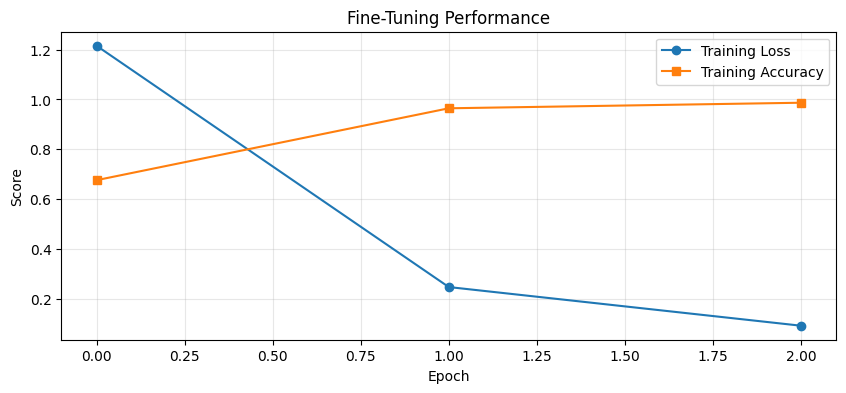

✅ Training complete!


In [ ]:
# CELL 7C: MULTIMODAL FINE-TUNING

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm import tqdm

print("🚀 Initializing Training ...")

# Device Setup
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️ Using device: {DEVICE}")

# 1. DATASET WITH TOKENIZATION
class RealFashionDataset(Dataset):
    def __init__(self, items, processor, transform=None):
        self.items = items
        self.processor = processor
        self.transform = transform

        # Create Label Mapping (Category Name -> Integer ID)
        self.categories = sorted(list(set(item['category'] for item in items)))
        self.label_map = {name: i for i, name in enumerate(self.categories)}
        self.num_classes = len(self.categories)

        print(f"   📦 Training on {self.num_classes} classes: {self.categories[:5]}...")

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        try:
            item = self.items[idx]
            image = item['image']
            text = f"A photo of a {item['name']}"

            # 1. Image Transform (Augmentation)
            if self.transform:
                image = self.transform(image)

            # 2. Text Tokenization (CLIP Tokenizer)
            text_inputs = self.processor(text=[text], return_tensors="pt", padding="max_length", truncation=True, max_length=77)

            label_id = self.label_map[item['category']]

            return {
                'image': image,
                'input_ids': text_inputs['input_ids'].squeeze(0),
                'attention_mask': text_inputs['attention_mask'].squeeze(0),
                'label': torch.tensor(label_id, dtype=torch.long)
            }
        except Exception as e:
            print(f"❌ Error at idx {idx}: {type(e).__name__}: {e}")
            # Return next valid sample to prevent crash
            return self.__getitem__((idx + 1) % len(self))

# 2. AUGMENTATION PIPELINE
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # 256px thumbnail → 224px for CLIP
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.481, 0.457, 0.408], std=[0.268, 0.261, 0.275])
])

# 3. FUSION MODEL
class RealFusionNetwork(nn.Module):
    def __init__(self, backbone_model, num_classes):
        super().__init__()
        self.backbone = backbone_model

        # Freeze Backbone (Transfer Learning)
        for param in self.backbone.parameters():
            param.requires_grad = False

        # Fusion Head
        self.fusion_mlp = nn.Sequential(
            nn.Linear(1024, 512),  # 512 (Image) + 512 (Text) = 1024
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, images, input_ids, attention_mask):
        # 1. Get Real Features from Backbone (No Grad)
        with torch.no_grad():
            img_features = self.backbone.get_image_features(pixel_values=images)
            txt_features = self.backbone.get_text_features(input_ids=input_ids, attention_mask=attention_mask)

            # Normalize
            img_features = img_features / img_features.norm(p=2, dim=-1, keepdim=True)
            txt_features = txt_features / txt_features.norm(p=2, dim=-1, keepdim=True)

        # 2. Concatenate
        combined = torch.cat((img_features, txt_features), dim=1)

        # 3. Classify
        logits = self.fusion_mlp(combined)
        return logits

# 4. TRAINING LOOP
def train_fusion(items, clip_model, clip_processor, epochs=2):
    print(f"🏋️ Starting Real Fine-Tuning (Head Training)...")

    try:
        # Setup Data
        dataset = RealFashionDataset(items, clip_processor, transform=train_transforms)
        dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

        # Setup Model
        model = RealFusionNetwork(clip_model, dataset.num_classes).to(DEVICE)

        # Optimizer (Only optimize the fusion_mlp parameters)
        optimizer = optim.Adam(model.fusion_mlp.parameters(), lr=1e-3)
        criterion = nn.CrossEntropyLoss()

        # Metric History
        history = {'loss': [], 'accuracy': []}

        model.train()

        for epoch in range(epochs):
            epoch_loss = 0
            correct = 0
            total = 0

            progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")

            for batch in progress_bar:
                # Move to GPU
                images = batch['image'].to(DEVICE)
                input_ids = batch['input_ids'].to(DEVICE)
                mask = batch['attention_mask'].to(DEVICE)
                labels = batch['label'].to(DEVICE)

                # Zero Grad
                optimizer.zero_grad()

                # Forward
                outputs = model(images, input_ids, mask)
                loss = criterion(outputs, labels)

                # Backward
                loss.backward()
                optimizer.step()

                # Metrics
                epoch_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                progress_bar.set_postfix({'loss': loss.item(), 'acc': correct/total})

            avg_loss = epoch_loss / len(dataloader)
            avg_acc = correct / total
            history['loss'].append(avg_loss)
            history['accuracy'].append(avg_acc)

            print(f"   ✅ Epoch {epoch+1} Summary: Loss={avg_loss:.4f}, Accuracy={avg_acc:.4f}")

        return model, history

    except Exception as e:
        print(f"❌ Training failed: {type(e).__name__}: {e}")
        raise

# --- EXECUTE TRAINING ---
if 'clip_encoder' in globals():
    raw_model = clip_encoder.model
    raw_processor = clip_encoder.processor

    trained_fusion_model, train_history = train_fusion(
        processed_items,
        raw_model,
        raw_processor,
        epochs=3
    )

    # Evaluation Plots
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 4))
    plt.plot(train_history['loss'], label='Training Loss', marker='o')
    plt.plot(train_history['accuracy'], label='Training Accuracy', marker='s')
    plt.title("Fine-Tuning Performance")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    print("✅ Training complete!")

else:
    raise RuntimeError("⚠️ 'clip_encoder' not found. Please run Cell 4 first!")

In [ ]:
# CELL 7D: EVALUATION METRICS

from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score

# 1. DEFINE FUNCTION FIRST
def evaluate_model(model, dataloader, device):
    """Compute Precision, Recall, F1 on validation set"""
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            images = batch['image'].to(device)
            input_ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(images, input_ids, mask)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

    print(f"📊 Evaluation Metrics:")
    print(f"   Precision: {precision:.4f}")
    print(f"   Recall:    {recall:.4f}")
    print(f"   F1-Score:  {f1:.4f}")

    return {'precision': precision, 'recall': recall, 'f1': f1}

# 2. THEN CREATE DATALOADER AND RUN
eval_dataset = RealFashionDataset(processed_items, raw_processor, transform=train_transforms)
dataloader = DataLoader(eval_dataset, batch_size=32, shuffle=False)

if 'trained_fusion_model' in globals():
    eval_metrics = evaluate_model(trained_fusion_model, dataloader, DEVICE)

   📦 Training on 19 classes: ['cape', 'cardigan', 'coat', 'dress', 'glasses']...
📊 Evaluation Metrics:
   Precision: 0.9826
   Recall:    0.9907
   F1-Score:  0.9864


In [ ]:
# CELL 8: LLM 1B MODEL

import gc
import torch
torch.cuda.empty_cache()
gc.collect()

from unsloth import FastLanguageModel
from typing import List, Dict

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1B model i(is the smaller)
LLM_MODEL = "unsloth/Llama-3.2-1B-Instruct-bnb-4bit"

print("Loading 1B LLM...")

llm_model, llm_tokenizer = FastLanguageModel.from_pretrained(
    model_name=LLM_MODEL,
    max_seq_length=1024,
    load_in_4bit=True,
    dtype=None,
)

FastLanguageModel.for_inference(llm_model)
print(" LLM loaded!")

def generate_response(user_query: str, retrieved_products: List[Dict], intent: str) -> str:
    # --- LAYER 1: CLEAN THE INPUT ---
    # Build the context string carefully. Ensure we strictly select only text fields.
    # Do NOT dump the whole dictionary, which might contain scores like {'score': 0.52}.
    product_context_list = []
    for i, p in enumerate(retrieved_products[:3]):
        # Fallbacks for missing keys so the code doesn't break
        name = p.get('name', 'Unknown Item')
        category = p.get('category', 'Fashion Item')
        # Ensure 'details' doesn't accidentally contain numbers from your database
        details = p.get('description', 'A great style choice.')

        entry = f"Option {i+1}: {name} ({category}) - {details}"
        product_context_list.append(entry)

    product_context = "\n".join(product_context_list)

    # --- LAYER 2: STRICT PROMPT ---
    prompt = f"""<|begin_of_text|><|start_header_id|>system<|end_header_id|>
You are a fashion stylist assistant.
Your Goal: Recommend the items listed below to the user based on their request.

STRICT RULES:
1. Do NOT mention percentages, confidence scores, or numbers like "52%".
2. Do NOT mention "match score" or technical details.
3. Only discuss the style, color, and fabric of the items.
4. Keep the response natural and helpful.<|eot_id|><|start_header_id|>user<|end_header_id|>
User Request: "{user_query}"

Available Items:
{product_context}<|eot_id|><|start_header_id|>assistant<|end_header_id|>
"""

    try:
        inputs = llm_tokenizer(prompt, return_tensors="pt").to(DEVICE)

        outputs = llm_model.generate(
            **inputs,
            max_new_tokens=300,
            temperature=0.6,
            repetition_penalty=1.1,
            do_sample=True,
            pad_token_id=llm_tokenizer.eos_token_id
        )

        raw_response = llm_tokenizer.decode(outputs[0], skip_special_tokens=True).split("assistant")[-1].strip()

        # --- LAYER 3: CLEAN THE OUTPUT (The Fail-Safe) ---
        # This regex removes any number followed by a % sign (e.g., "52%", "100%")
        # and replaces it with an empty string.
        clean_response = re.sub(r'\b\d+%\b', '', raw_response)

        # Optional: Remove double spaces created by the deletion
        clean_response = re.sub(r'\s+', ' ', clean_response).strip()

        return clean_response

    except Exception as e:
        return f"Check out this option: {retrieved_products[0]['name']}"

print("✅ Ready!")

/tmp/ipython-input-868140246.py:8: UserWarning: WARNING: Unsloth should be imported before [transformers] to ensure all optimizations are applied. Your code may run slower or encounter memory issues without these optimizations.

Please restructure your imports with 'import unsloth' at the top of your file.
  from unsloth import FastLanguageModel


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
Loading 1B LLM...
==((====))==  Unsloth 2026.1.4: Fast Llama patching. Transformers: 4.57.6.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.10.0+cu128. CUDA: 7.5. CUDA Toolkit: 12.8. Triton: 3.6.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.34. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/1.03G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

 LLM loaded!
✅ Ready!


In [ ]:
# CELL 9:

from typing import Dict, List, Optional
import logging
import torch
from transformers import BertTokenizer

logger = logging.getLogger(__name__)
TOP_K_RESULTS = 5
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
INTENT_LABELS = {0: "SEARCH", 1: "RECOMMEND", 2: "COMPARE", 3: "DETAILS", 4: "SIMILAR"}

# Load tokenizer again
intent_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

class FashionChatbot:
    """Complete multimodal fashion assistant"""

    def __init__(self, clip_encoder, intent_classifier, search_index, audio_transcriber=None, fusion_model=None):
        self.clip = clip_encoder
        self.intent_model = intent_classifier
        self.index = search_index
        self.audio = audio_transcriber
        self.fusion_model = fusion_model # Add fusion_model to init
        print(" Chatbot ready!")

    def classify_intent(self, text: str) -> str:
        """Classify user intent using BERT model"""
        self.intent_model.eval()
        with torch.no_grad():
            inputs = intent_tokenizer(text, return_tensors="pt", truncation=True, max_length=128).to(DEVICE)
            outputs = self.intent_model(inputs["input_ids"], inputs["attention_mask"])
            pred = torch.argmax(outputs, dim=1).item()
        return INTENT_LABELS.get(pred, "SEARCH")

    def predict_category_fusion(self, image, text):

        if not self.fusion_model:
            return "Unknown"

        # This part assumes a specific structure for fusion_model prediction
        # For now, it's a placeholder. A proper implementation would need
        # to align with the RealFusionNetwork's forward method.
        # Example (simplified, assuming fusion_model expects raw image and tokenized text):
        try:
            # Preprocess image and text similarly to RealFashionDataset __getitem__
            # This might require passing raw_processor to chatbot or making clip_processor accessible
            # For simplicity, using clip encoder here, but fusion model might need different inputs

            # If fusion model needs image processed for it:
            img_processed = self.clip.processor(images=image, return_tensors="pt").pixel_values.to(DEVICE)
            txt_tokenized = self.clip.processor(text=[text], return_tensors="pt", padding="max_length", truncation=True, max_length=77).to(DEVICE)

            with torch.no_grad():
                outputs = self.fusion_model(img_processed, txt_tokenized['input_ids'], txt_tokenized['attention_mask'])
                _, predicted_idx = torch.max(outputs, 1)
                # Need access to the dataset's category list to map idx back to name
                # For now, return a placeholder or 'Unknown'
                return "Predicted_Category_Placeholder" # Replace with actual mapping
        except Exception as e:
            logger.error(f"Fusion model prediction failed: {e}")
            return "Unknown"

    def process_query(self, text: str = None, image = None, audio_path: str = None,
                          weights={'image': 0.50, 'text': 0.35, 'audio': 0.15}) -> Dict:

            # --- 1. PRE-PROCESSING & FUSION (Keep your Weighted Logic) ---
            emb_dim = 512
            img_emb = np.zeros(emb_dim, dtype='float32')
            txt_emb = np.zeros(emb_dim, dtype='float32')
            aud_emb = np.zeros(emb_dim, dtype='float32')
            active_modalities = []
            transcribed_text = ""

            # Process Inputs
            if audio_path and self.audio:
                transcribed_text = self.audio.transcribe_file(audio_path) # Use transcribe_file for path
                if transcribed_text:
                    aud_emb = self.clip.encode_text(transcribed_text)
                    active_modalities.append('audio')
                    if not text: text = transcribed_text

            if text:
                txt_emb = self.clip.encode_text(text)
                active_modalities.append('text')

            if image is not None:
                img_emb = self.clip.encode_image(image)
                active_modalities.append('image')

            if not active_modalities:
                return {"error": "No input", "response": "Please provide input.", "products": []}

            # Weighted Average
            current_weights = {k: weights[k] for k in active_modalities}
            total_weight = sum(current_weights.values())
            final_embedding = np.zeros(emb_dim, dtype='float32')

            if 'image' in active_modalities: final_embedding += img_emb * (weights['image']/total_weight)
            if 'text' in active_modalities: final_embedding += txt_emb * (weights['text']/total_weight)
            if 'audio' in active_modalities: final_embedding += aud_emb * (weights['audio']/total_weight)

            norm = np.linalg.norm(final_embedding)
            if norm > 0: final_embedding = final_embedding / norm

            # --- 2. SEARCH ---
            products = self.index.search(final_embedding, k=TOP_K_RESULTS)

            # --- 3. FILTERING (The Fix) ---
            valid_products = [p for p in products if p['score'] > 0.27]

            intent = self.classify_intent(text if text else "SEARCH")

            if not valid_products:
                 return {
                    "intent": intent,
                    "predicted_category": None,
                    "query": text,
                    "products": [],
                    "response": "I couldn't find any fashion items matching that description. Can you try something else?"
                }

            # --- 4. PREDICTION & GENERATION ---
            predicted_category = "Unknown"
            # Check if fusion_model exists before trying to use it
            if self.fusion_model is not None and image is not None and text is not None:
                try:
                    cat_pred = self.predict_category_fusion(image, text)
                    if cat_pred: predicted_category = cat_pred
                except Exception as e:
                    logger.warning(f"Error during fusion model prediction: {e}")
                    pass # Keep 'Unknown'

            context_text = text if text else transcribed_text
            if predicted_category != "Unknown":
                context_text += f" (Looking for: {predicted_category})"

            # Pass 'valid_products' to the generator
            response_text = generate_response(context_text, valid_products, intent)

            return {
                "intent": intent,
                "predicted_category": predicted_category,
                "query": text,
                "products": valid_products, # Return the filtered list
                "response": response_text
            }

# Initialize
print("🤖 Initializing chatbot...")
chatbot = FashionChatbot(
    clip_encoder=clip_encoder,
    intent_classifier=intent_classifier,
    search_index=search_index,
    audio_transcriber=audio_transcriber if 'audio_transcriber' in globals() else None, # Use globals() to check for variable existence
    fusion_model=trained_fusion_model if 'trained_fusion_model' in globals() else None # Pass the trained fusion model
)

# Test
print("\n📝 Test 1: Text-only query")
result = chatbot.process_query(text="I need a casual summer outfit")
print(f"Intent: {result['intent']}")
print(f"Products found: {len(result['products'])}")
print(f"Response: {result['response'][:200]}...")

🤖 Initializing chatbot...
 Chatbot ready!

📝 Test 1: Text-only query
Intent: RECOMMEND
Products found: 0
Response: I couldn't find any fashion items matching that description. Can you try something else?...


In [ ]:
%%writefile app.py
# app.py - Multimodal Fashion Assistant

import streamlit as st
import torch
import numpy as np
from PIL import Image
import faiss
import pickle
import io
import tempfile
import librosa
from transformers import CLIPProcessor, CLIPModel, WhisperProcessor, WhisperForConditionalGeneration
from unsloth import FastLanguageModel

st.set_page_config(page_title="Fashion Assistant", layout="wide", page_icon="👗")
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# ===== CACHED MODEL LOADING =====
@st.cache_resource
def load_prebuilt_data():
    with open('fashion_data.pkl', 'rb') as f:
        data = pickle.load(f)
    index = faiss.deserialize_index(data['index'])
    products = []
    for p in data['products']:
        prod = {'name': p['name'], 'category': p['category']}
        if p.get('image_bytes'):
            prod['image'] = Image.open(io.BytesIO(p['image_bytes']))
        products.append(prod)
    return index, products

@st.cache_resource
def load_clip():
    clip = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(DEVICE)
    proc = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
    return clip, proc

@st.cache_resource
def load_whisper():
    model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-base").to(DEVICE)
    proc = WhisperProcessor.from_pretrained("openai/whisper-base")
    return model, proc

@st.cache_resource
def load_llm():
    llm, tok = FastLanguageModel.from_pretrained(
        "unsloth/Llama-3.2-1B-Instruct-bnb-4bit", max_seq_length=512, load_in_4bit=True
    )
    FastLanguageModel.for_inference(llm)
    return llm, tok

# Load models
with st.spinner("🔄 Loading models... Please wait"):
    faiss_index, products = load_prebuilt_data()
    clip, clip_proc = load_clip()
    whisper, whisper_proc = load_whisper()
    llm, llm_tok = load_llm()

# ===== HELPER FUNCTIONS =====
def encode_text(text):
    q = clip_proc(text=["a photo of " + text], return_tensors="pt", padding=True).to(DEVICE)
    with torch.no_grad():
        e = clip.get_text_features(**q)
        e = e / e.norm(dim=-1, keepdim=True)
    return e.cpu().numpy()

def encode_image(img):
    inputs = clip_proc(images=img, return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        e = clip.get_image_features(**inputs)
        e = e / e.norm(dim=-1, keepdim=True)
    return e.cpu().numpy()

def transcribe_audio(audio_bytes):
    try:
        with tempfile.NamedTemporaryFile(delete=False, suffix=".wav") as f:
            f.write(audio_bytes)
            audio, sr = librosa.load(f.name, sr=16000)
        inputs = whisper_proc(audio, sampling_rate=16000, return_tensors="pt").to(DEVICE)
        with torch.no_grad():
            ids = whisper.generate(**inputs)
        return whisper_proc.batch_decode(ids, skip_special_tokens=True)[0]
    except Exception as e:
        return None

def build_context(messages, max_turns=5):
    """Build conversation context from recent messages"""
    recent = messages[-max_turns*2:] if len(messages) > max_turns*2 else messages
    context = ""
    for msg in recent:
        role = "User" if msg["role"] == "user" else "Assistant"
        context += role + ": " + msg["text"] + chr(10)
    return context

def is_meta_command(text):
    """Detect if text is a command about the image, not a fashion description"""
    meta_phrases = [
        "similar to the image", "like this", "like the image",
        "find similar", "search similar", "match this",
        "something like this", "this style", "similar to this",
        "like the photo", "similar to the photo", "match the image",
        "parecido", "similar", "como este", "como la imagen"
    ]
    text_lower = text.lower()
    return any(phrase in text_lower for phrase in meta_phrases)

def generate_response(query, prods, context=""):
    """Generate LLM response with conversation context"""
    prod_list = ", ".join([p["name"] for p in prods[:3]])

    prompt = "<|begin_of_text|><|start_header_id|>system<|end_header_id|>"
    prompt += "You are a helpful fashion assistant. Give brief, friendly suggestions based on the products found. "
    prompt += "Use the conversation context to understand user preferences (gender, style, occasion). "
    prompt += "Never refuse reasonable fashion requests.<|eot_id|>"
    prompt += "<|start_header_id|>user<|end_header_id|>"

    if context:
        prompt += "Conversation history:" + chr(10) + context + chr(10) + chr(10)

    prompt += "Current request: " + query + chr(10)
    prompt += "Available products: " + prod_list
    prompt += "<|eot_id|><|start_header_id|>assistant<|end_header_id|>"

    try:
        out = llm.generate(**llm_tok(prompt, return_tensors="pt").to(DEVICE), max_new_tokens=150)
        response = llm_tok.decode(out[0], skip_special_tokens=True).split("assistant")[-1].strip()
        return response if response else "Here are some options that might interest you!"
    except:
        return "Here are some fashion items I found for you!"

def perform_search(text_query, image_query, voice_query):
    """
    Multimodal search with weighted embeddings:
    - Image only: 100% image
    - Text only: 100% text
    - Voice only: 100% voice
    - Image + Text: 70% image, 30% text
    - Image + Voice: 70% image, 30% voice
    - Text + Voice: 50% text, 50% voice
    - All three: 50% image, 25% text, 25% voice
    """
    embeddings = []
    weights = []
    description_parts = []

    # Detect meta-commands
    text_is_meta = text_query and is_meta_command(text_query)

    # === IMAGE ===
    if image_query is not None:
        img_emb = encode_image(image_query)
        embeddings.append(img_emb)
        description_parts.append("📷 Image")

        if text_is_meta:
            weights.append(1.0)
        elif text_query and voice_query:
            weights.append(0.50)
        elif text_query or voice_query:
            weights.append(0.70)
        else:
            weights.append(1.0)

    # === TEXT ===
    if text_query and not text_is_meta:
        txt_emb = encode_text(text_query)
        embeddings.append(txt_emb)
        description_parts.append("📝 Text")

        if image_query is not None and voice_query:
            weights.append(0.25)
        elif image_query is not None:
            weights.append(0.30)
        elif voice_query:
            weights.append(0.50)
        else:
            weights.append(1.0)

    # === VOICE ===
    if voice_query:
        voice_emb = encode_text(voice_query)
        embeddings.append(voice_emb)
        description_parts.append("🎤 Voice")

        if image_query is not None and text_query and not text_is_meta:
            weights.append(0.25)
        elif image_query is not None:
            weights.append(0.30)
        elif text_query:
            weights.append(0.50)
        else:
            weights.append(1.0)

    if not embeddings:
        return None, "", ""

    # Combine embeddings with weights
    query_emb = np.zeros_like(embeddings[0])
    for emb, w in zip(embeddings, weights):
        query_emb += emb * w
    query_emb = query_emb / np.linalg.norm(query_emb)

    # Build final text for LLM
    final_text = ""
    if voice_query:
        final_text = voice_query
    if text_query and not text_is_meta:
        final_text = (final_text + " " + text_query).strip()
    if not final_text:
        final_text = "Similar items to uploaded image"

    query_desc = " + ".join(description_parts)

    return query_emb, final_text, query_desc

def do_search(text_q, img_q, voice_q):
    """Execute search and return results"""
    query_emb, final_text, query_desc = perform_search(text_q, img_q, voice_q)

    if query_emb is None:
        return None, None, None, None

    scores, ids = faiss_index.search(query_emb, 10)
    results = []
    for s, i in zip(scores[0], ids[0]):
        if 0 <= i < len(products):
            p = products[i].copy()
            p["similarity"] = max(0, min(100, float(s) * 100))
            results.append(p)
    results = results[:5]

    return results, final_text, query_desc, query_emb

# ===== SESSION STATE =====
if "messages" not in st.session_state:
    st.session_state.messages = []
if "current_image" not in st.session_state:
    st.session_state.current_image = None
if "current_voice" not in st.session_state:
    st.session_state.current_voice = None
if "current_text" not in st.session_state:
    st.session_state.current_text = ""
if "file_uploader_key" not in st.session_state:
    st.session_state.file_uploader_key = 0
if "audio_processed" not in st.session_state:
    st.session_state.audio_processed = False
if "image_processed" not in st.session_state:
    st.session_state.image_processed = False
if "auto_search_voice" not in st.session_state:
    st.session_state.auto_search_voice = False
if "auto_search_image" not in st.session_state:
    st.session_state.auto_search_image = False

# ===== MAIN UI =====
st.title("👗 Fashion Assistant")
st.caption("🛍️ " + str(len(products)) + " products loaded | Multimodal Search: Text, Image & Voice")

# ===== SIDEBAR =====
with st.sidebar:
    st.header("🎯 How to Search")

    st.info("""
    **Use any input method:**
    - 📝 **Text** - Describe what you want
    - 📷 **Image** - Upload a photo (auto-search)
    - 🎤 **Voice** - Record your request (auto-search)

    **Or combine them** for better results!
    """)

    st.divider()

    # --- TEXT INPUT ---
    st.subheader("📝 Text Query")
    text_input = st.text_area(
        "Describe what you want",
        value=st.session_state.current_text,
        placeholder="e.g., blue summer dress, casual jacket for wedding...",
        height=80,
        key="text_area_" + str(st.session_state.file_uploader_key),
        help="Type any fashion item, style, or occasion"
    )
    if text_input:
        st.session_state.current_text = text_input.strip()

    st.divider()

    # --- IMAGE INPUT (AUTO-SEARCH) ---
    st.subheader("📷 Image Search")
    st.caption("Upload a photo → Auto search similar items")
    uploaded_image = st.file_uploader(
        "Upload fashion image",
        type=["jpg", "jpeg", "png"],
        key="img_" + str(st.session_state.file_uploader_key),
        help="Upload a photo to find similar styles automatically"
    )

    if uploaded_image and not st.session_state.image_processed:
        img = Image.open(uploaded_image).convert("RGB")
        st.session_state.current_image = img
        st.image(img, caption="✅ Image loaded - Searching...", use_container_width=True)
        st.session_state.image_processed = True
        st.session_state.auto_search_image = True
        st.rerun()
    elif st.session_state.current_image:
        st.image(st.session_state.current_image, caption="✅ Current image", use_container_width=True)

    st.divider()

    # --- VOICE INPUT (AUTO-TRANSCRIBE + AUTO-SEARCH) ---
    st.subheader("🎤 Voice Input")
    st.caption("Upload audio → Auto transcribe & search")
    uploaded_audio = st.file_uploader(
        "Upload voice recording",
        type=["wav", "mp3", "m4a"],
        key="audio_" + str(st.session_state.file_uploader_key),
        help="Upload audio - will transcribe and search automatically"
    )

    if uploaded_audio and not st.session_state.audio_processed:
        st.audio(uploaded_audio)
        with st.spinner("🎙️ Transcribing..."):
            transcribed = transcribe_audio(uploaded_audio.read())
            if transcribed and transcribed.strip():
                st.session_state.current_voice = transcribed.strip()
                st.session_state.audio_processed = True
                st.success("✅ " + transcribed)
                st.session_state.auto_search_voice = True
                st.rerun()
            else:
                st.error("❌ Could not transcribe audio. Please try again.")

    if st.session_state.current_voice:
        st.success("🎤 " + st.session_state.current_voice)

    st.divider()

    # --- ACTIVE INPUTS SUMMARY ---
    active_inputs = []
    if st.session_state.current_text:
        active_inputs.append("📝 Text")
    if st.session_state.current_image:
        active_inputs.append("📷 Image")
    if st.session_state.current_voice:
        active_inputs.append("🎤 Voice")

    if active_inputs:
        st.success("**Active inputs:** " + " + ".join(active_inputs))
    else:
        st.warning("💡 Add text, image, or voice to search")

    # --- BUTTONS ---
    col1, col2 = st.columns(2)
    with col1:
        search_button = st.button("🔍 Search", type="primary", use_container_width=True)
    with col2:
        clear_button = st.button("🗑️ Clear All", use_container_width=True)

    if clear_button:
        st.session_state.messages = []
        st.session_state.current_image = None
        st.session_state.current_voice = None
        st.session_state.current_text = ""
        st.session_state.audio_processed = False
        st.session_state.image_processed = False
        st.session_state.auto_search_voice = False
        st.session_state.auto_search_image = False
        st.session_state.file_uploader_key += 1
        st.rerun()

    st.divider()
    st.caption("💡 **Tip:** The more inputs you provide, the better the results!")

# ===== CHAT HISTORY =====
for msg in st.session_state.messages:
    with st.chat_message(msg["role"]):
        st.write(msg["text"])
        if msg.get("products"):
            cols = st.columns(min(5, len(msg["products"])))
            for i, p in enumerate(msg["products"][:5]):
                with cols[i]:
                    if p.get("image"):
                        st.image(p["image"], use_container_width=True)
                    st.caption(p["name"])
                    similarity = int(min(100, max(0, p.get("similarity", 50))))
                    st.progress(similarity)
                    st.caption(str(similarity) + "% match")

# ===== AUTO-SEARCH: IMAGE =====
if st.session_state.auto_search_image and st.session_state.current_image:
    st.session_state.auto_search_image = False

    results, final_text, query_desc, _ = do_search("", st.session_state.current_image, "")

    if results:
        st.session_state.messages.append({"role": "user", "text": "📷 [Image search]"})

        context = build_context(st.session_state.messages)
        response = generate_response(final_text, results, context)

        st.session_state.messages.append({
            "role": "assistant",
            "text": response,
            "products": results
        })

        # Clear image after search
        st.session_state.current_image = None
        st.session_state.image_processed = False
        st.session_state.file_uploader_key += 1
        st.rerun()

# ===== AUTO-SEARCH: VOICE =====
if st.session_state.auto_search_voice and st.session_state.current_voice:
    st.session_state.auto_search_voice = False

    results, final_text, query_desc, _ = do_search("", None, st.session_state.current_voice)

    if results:
        st.session_state.messages.append({"role": "user", "text": "🎤 " + st.session_state.current_voice})

        context = build_context(st.session_state.messages)
        response = generate_response(final_text, results, context)

        st.session_state.messages.append({
            "role": "assistant",
            "text": response,
            "products": results
        })

        # Clear voice after search
        st.session_state.current_voice = None
        st.session_state.audio_processed = False
        st.session_state.file_uploader_key += 1
        st.rerun()

# ===== MANUAL SEARCH BUTTON =====
if search_button:
    text_q = st.session_state.current_text
    img_q = st.session_state.current_image
    voice_q = st.session_state.current_voice

    if not text_q and not img_q and not voice_q:
        st.warning("⚠️ Please add at least one input (text, image, or voice)!")
    else:
        results, final_text, query_desc, _ = do_search(text_q, img_q, voice_q)

        if results:
            # Build user message
            user_msg_parts = []
            if voice_q:
                user_msg_parts.append("🎤 " + voice_q)
            if text_q:
                user_msg_parts.append("📝 " + text_q)
            if img_q:
                user_msg_parts.append("📷 [image]")
            user_msg = " | ".join(user_msg_parts)

            st.session_state.messages.append({"role": "user", "text": user_msg})

            context = build_context(st.session_state.messages)
            response = generate_response(final_text, results, context)

            st.session_state.messages.append({
                "role": "assistant",
                "text": response,
                "products": results
            })

            # Clear all inputs
            st.session_state.current_image = None
            st.session_state.current_voice = None
            st.session_state.current_text = ""
            st.session_state.audio_processed = False
            st.session_state.image_processed = False
            st.session_state.file_uploader_key += 1
            st.rerun()
        else:
            st.error("❌ No results found. Try a different search.")

# ===== QUICK CHAT INPUT =====
st.divider()
prompt = st.chat_input("💬 Quick text search (or use sidebar for multimodal)")

if prompt:
    # Check if there's an image in sidebar to combine
    img_q = st.session_state.current_image

    results, final_text, query_desc, _ = do_search(prompt, img_q, None)

    if results:
        user_msg = prompt
        if img_q:
            user_msg += " 📷"

        st.session_state.messages.append({"role": "user", "text": user_msg})

        context = build_context(st.session_state.messages)
        response = generate_response(final_text, results, context)

        st.session_state.messages.append({
            "role": "assistant",
            "text": response,
            "products": results
        })

        # Clear image if used
        if img_q:
            st.session_state.current_image = None
            st.session_state.image_processed = False
            st.session_state.file_uploader_key += 1

        st.rerun()
    else:
        st.warning("No results found. Try different keywords.")

Writing app.py


In [ ]:
# CELL 11: STREAMLIT WITH NGROK

# Install ngrok
!pip install -q pyngrok

from pyngrok import ngrok
import subprocess
import time


NGROK_TOKEN = "374PsiGvVhW7UqpMna673SvzuWP_3EpvNX9W4uxYFo2iccwBX"

if NGROK_TOKEN:
    ngrok.set_auth_token(NGROK_TOKEN)

# Kill any existing Streamlit processes
!pkill -f streamlit

# Start Streamlit in background
process = subprocess.Popen(
    ['streamlit', 'run', 'app.py', '--server.port', '8501'],
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE
)

# Waiting to start
time.sleep(5)

# Create ngrok tunnel
try:
    # Close existing tunnels
    tunnels = ngrok.get_tunnels()
    for tunnel in tunnels:
        ngrok.disconnect(tunnel.public_url)

    # Create new tunnel
    public_url = ngrok.connect(8501)
    print(f"\n Fashion Chatbot is live at:")
    print(f"   {public_url}")
    print(f"\n Note: Give some time while models initialize")

except Exception as e:
    print(f"❌ Failed to create tunnel: {e}")
    print("Alternative: Use localtunnel with: !npx localtunnel --port 8501")